# Neural Language Modeling

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('data/ratings_train.txt', sep='\t')

In [3]:
df.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
df.shape

(150000, 3)

In [5]:
df['label'].value_counts()

label
0    75173
1    74827
Name: count, dtype: int64

In [6]:
df.isna().sum()

id          0
document    5
label       0
dtype: int64

In [7]:
df.loc[df['document'].isna(), :]

,id,document,label
25857,2172111,NaN,1
55737,6369843,NaN,1
110014,1034280,NaN,0
126782,5942978,NaN,0
140721,1034283,NaN,0


In [8]:
df = df.dropna(how='any', axis=0)

In [9]:
df.shape

(149995, 3)

---
## Tokenization

In [10]:
vocab_cnt_dict = {} 
for doc in df['document']:
    for token in list(doc):
        if token not in vocab_cnt_dict:
            vocab_cnt_dict[token] = 0
        vocab_cnt_dict[token] += 1

In [11]:
vocab_cnt_list = [(token, cnt) for token, cnt in vocab_cnt_dict.items()]

In [12]:
vocab_cnt_list[:10]

[('아', 47071),
 (' ', 987741),
 ('더', 9863),
 ('빙', 738),
 ('.', 241461),
 ('진', 18522),
 ('짜', 11514),
 ('증', 2160),
 ('나', 42976),
 ('네', 18756)]

In [13]:
len(vocab_cnt_list)

3004

In [14]:
top_vocabs = sorted(vocab_cnt_list, key=lambda tup:tup[1], reverse=True)

In [15]:
import matplotlib.pyplot as plt
import numpy as np

In [16]:
cnts = [cnt for _, cnt in top_vocabs]

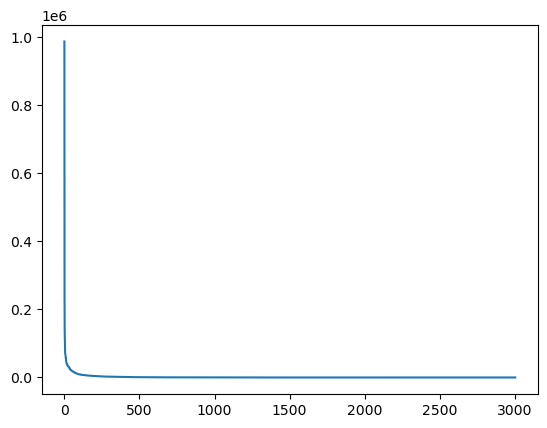

In [17]:
plt.plot(range(len(cnts)), cnts)

In [18]:
np.mean(cnts)

1757.8239014647138

In [19]:
vocabs = [token for token, _ in vocab_cnt_list]

In [20]:
len(vocabs)

3004

---
## Add Special Tokens

In [21]:
# pad, unk, sos, eos
special_tokens = ['[PAD]', '[UNK]', '[SOS]', '[EOS]']
for special_token in special_tokens[::-1]:
    vocabs.insert(0, special_token)

In [22]:
idx_to_token = vocabs
token_to_idx = {token: i for i, token in enumerate(idx_to_token)}

In [23]:
class Tokenizer:
    def __init__(self,
                 vocabs,
                 use_padding=True,
                 max_padding=64,
                 pad_token='[PAD]',
                 unk_token='[UNK]',
                 sos_token='[SOS]',
                 eos_token='[EOS]'):
        self.idx_to_token = vocabs
        self.token_to_idx = {token: i for i, token in enumerate(self.idx_to_token)}
        
        self.use_padding = use_padding
        self.max_padding = max_padding
        
        self.pad_token = pad_token
        self.unk_token = unk_token
        self.sos_token = sos_token
        self.eos_token = eos_token
        
        self.unk_token_idx = self.token_to_idx[self.unk_token]
        self.pad_token_idx = self.token_to_idx[self.pad_token]
        self.sos_token_idx = self.token_to_idx[self.sos_token]
        self.eos_token_idx = self.token_to_idx[self.eos_token]
        
        
    def __call__(self, x):
        token_ids = [self.sos_token_idx]
        
        token_list = list(x)
        
        for token in token_list:
            if token in self.token_to_idx:
                token_idx = self.token_to_idx[token]
            else:
                token_idx = self.unk_token_idx
            token_ids.append(token_idx)
            
        token_ids.append(self.eos_token_idx)
            
        if self.use_padding:
            token_ids.pop()
            token_ids = token_ids[:self.max_padding-1]
            n_pads = self.max_padding - len(token_ids) - 1
            token_ids = token_ids + [self.eos_token_idx] +[self.pad_token_idx] * n_pads
        
        return token_ids
    
    def cvt_ids_to_tokens(self, ids):
        return [self.idx_to_token[idx] for idx in ids]
    
    def cvt_ids_to_str(self, ids):
        return ''.join([self.idx_to_token[idx] for idx in ids])

In [24]:
tokenizer = Tokenizer(vocabs, use_padding=False)

In [25]:
sample = df['document'].iloc[0]
print(sample)

아 더빙.. 진짜 짜증나네요 목소리


In [26]:
tokenizer(sample)

[2, 4, 5, 6, 7, 8, 8, 5, 9, 10, 5, 10, 11, 12, 13, 14, 5, 15, 16, 17, 3]

---
## DataLoader

In [27]:
import torch
from torch.utils.data import Dataset, DataLoader

In [28]:
train_valid_df = pd.read_csv('data/ratings_train.txt', sep='\t')
test_df = pd.read_csv('data/ratings_test.txt', sep='\t')

In [29]:
train_valid_df.shape, test_df.shape

((150000, 3), (50000, 3))

In [30]:
train_ratio = 0.8

n_train = int(len(train_valid_df) * train_ratio)

train_df = train_valid_df[:n_train]
valid_df = train_valid_df[n_train:]

In [31]:
train_df = train_df.sample(frac=0.01)
valid_df = valid_df.sample(frac=0.01)
test_df = test_df.sample(frac=0.01)

In [32]:
class NSMCDataset(Dataset):
    
    def __init__(self, data_df, tokenizer=None):
        self.data_df = data_df
        self.tokenizer = tokenizer
        
    
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, idx):
        sample_raw = self.data_df.iloc[idx]
        sample = {}
        
        sample['doc'] = str(sample_raw['document'])
        
        if self.tokenizer is not None:
            sample['doc_ids'] = self.tokenizer(sample['doc']) 
        
        return sample

In [33]:
def collate_fn(batch):
    keys = [key for key in batch[0].keys()]
    data = {key: [] for key in keys}

    for item in batch:
        for key in keys:
            data[key].append(item[key])
    return data

In [34]:
train_dataset = NSMCDataset(data_df=train_df, tokenizer=tokenizer)
valid_dataset = NSMCDataset(data_df=valid_df, tokenizer=tokenizer)
test_dataset = NSMCDataset(data_df=test_df, tokenizer=tokenizer)

train_dataloader= DataLoader(train_dataset,
                             batch_size=128,
                             collate_fn=collate_fn,
                             shuffle=True)

valid_dataloader= DataLoader(valid_dataset,
                             batch_size=1024,
                             collate_fn=collate_fn,
                             shuffle=False)

test_dataloader= DataLoader(test_dataset,
                            batch_size=1024,
                            collate_fn=collate_fn,
                            shuffle=False)

In [35]:
sample = next(iter(test_dataloader))

---
## Autoregressive Self-Attention Model

In [36]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F


class AutoregressiveSelfAttention(nn.Module):

    def __init__(self,
                 vocab_size,
                 embed_dim):

        super().__init__()
        
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.output_dim = embed_dim

        self.embeddings = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        self.q_linear = nn.Linear(embed_dim, embed_dim)
        self.k_linear = nn.Linear(embed_dim, embed_dim)
        self.v_linear = nn.Linear(embed_dim, embed_dim)
        
    def forward(self, X, return_attention_score=False):

        batch_size, seq_len = X.size()
        X = self.embeddings(X)
        
        q, k, v = self.q_linear(X), self.k_linear(X), self.v_linear(X)
        
        attention_score_raw = q @ k.transpose(-2,-1) / math.sqrt(self.embed_dim)
        
        mask = torch.tril(torch.ones(seq_len,seq_len, device=X.device))
        
        attention_score_raw = attention_score_raw.masked_fill(mask==0.,-9e9)
        attention_score = torch.softmax(attention_score_raw, dim=2)
        
        context = attention_score @ v
        
        if return_attention_score:
            return context, attention_score
        return context

In [37]:
seq_len=3

torch.ones(seq_len,seq_len)

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])

In [38]:
mask = torch.tril(torch.ones(seq_len,seq_len))

In [39]:
mask

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])

In [40]:
x = torch.randn(2, 3, 3)

In [41]:
x

tensor([[[-0.7848, -0.7768, -0.7503],
         [-1.2415,  0.8825, -1.0155],
         [-2.3689,  0.3095,  0.9742]],

        [[ 1.1485,  1.4714,  2.2267],
         [-0.2451,  2.0191,  0.8585],
         [-0.2066, -0.7619, -0.8557]]])

In [42]:
x.masked_fill(mask==0, -9e-9)

tensor([[[-7.8481e-01, -9.0000e-09, -9.0000e-09],
         [-1.2415e+00,  8.8248e-01, -9.0000e-09],
         [-2.3689e+00,  3.0953e-01,  9.7424e-01]],

        [[ 1.1485e+00, -9.0000e-09, -9.0000e-09],
         [-2.4510e-01,  2.0191e+00, -9.0000e-09],
         [-2.0655e-01, -7.6189e-01, -8.5565e-01]]])

In [43]:
torch.softmax(x.masked_fill(mask==0, -9e9), dim=2)

tensor([[[1.0000, 0.0000, 0.0000],
         [0.1068, 0.8932, 0.0000],
         [0.0228, 0.3319, 0.6453]],

        [[1.0000, 0.0000, 0.0000],
         [0.0941, 0.9059, 0.0000],
         [0.4770, 0.2737, 0.2492]]])

In [44]:
class Classifier(nn.Module):
    
    def __init__(self, sr_model, output_dim, vocab_size, embed_dim, **kwargs):

        super().__init__()

        self.sr_model = sr_model(vocab_size=vocab_size,
                                 embed_dim=embed_dim,
                                 **kwargs)

        self.input_dim = self.sr_model.output_dim
        self.output_dim = output_dim
        self.fc = nn.Linear(self.input_dim, self.output_dim)

    def forward(self, x):
        return self.fc(self.sr_model(x))

In [45]:
model = Classifier(sr_model=AutoregressiveSelfAttention,
                   output_dim=len(vocabs),
                   vocab_size=len(vocabs),
                   embed_dim=128)

In [46]:
model.sr_model.embeddings.weight[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<SelectBackward0>)

---
## Training

In [47]:
use_cuda = True and torch.cuda.is_available()

if use_cuda:
    model.cuda()
print(f"use_cuda: {use_cuda}")

use_cuda: False


In [48]:
import torch.optim as optim
import numpy as np
from copy import deepcopy

In [49]:
optimizer = optim.Adam(params=model.parameters(), lr=0.01)
calc_loss = nn.CrossEntropyLoss(ignore_index=0)

In [50]:
tokenizer.use_padding = True
n_epoch = 100
global_i = 0

valid_loss_history = [] 
train_loss_history = [] 

min_valid_loss = 9e+9
best_model = None
best_epoch_i = None

ema_train_loss = None

for epoch_i in range(n_epoch):
    model.train()
    
    for batch in train_dataloader:
        optimizer.zero_grad()
        x = torch.tensor(batch['doc_ids'])
        if use_cuda:
            x = x.cuda()
        
        y_pred = model(x[:, :-1])
        loss = calc_loss(y_pred.view(-1, len(vocabs)), x[:, 1:].flatten())

        if global_i % 100 == 0:
            print(f"global_i: {global_i}, epoch_i: {epoch_i}, loss: {loss.item()}")
            
        train_loss_history.append((global_i, loss.item()))
            
        loss.backward()
        optimizer.step()
        global_i += 1
    
    model.eval()

    valid_loss_list = []
    for batch in valid_dataloader:
        x = torch.tensor(batch['doc_ids'])
        if use_cuda:
            x = x.cuda()
        y_pred = model(x[:, :-1])
        loss = calc_loss(y_pred.view(-1, len(vocabs)), x[:, 1:].flatten())
        valid_loss_list.append(loss.item())

    
    valid_loss_mean = np.mean(valid_loss_list)
    valid_loss_history.append((global_i, valid_loss_mean.item()))
    
    
    if valid_loss_mean < min_valid_loss:
        min_valid_loss = valid_loss_mean
        best_epoch_i = epoch_i
        best_model = deepcopy(model)
        
    if epoch_i % 5 == 0:
        print("*"*30)
        print(f"valid_loss_mean: {valid_loss_mean}")
        print("*"*30)
print(f"best_epoch_i: {best_epoch_i}")

global_i: 0, epoch_i: 0, loss: 8.017644882202148
******************************
valid_loss_mean: 5.22611665725708
******************************
******************************
valid_loss_mean: 4.735431671142578
******************************
global_i: 100, epoch_i: 10, loss: 4.3055195808410645
******************************
valid_loss_mean: 4.615505695343018
******************************
******************************
valid_loss_mean: 4.561903953552246
******************************
global_i: 200, epoch_i: 20, loss: 3.7931292057037354
******************************
valid_loss_mean: 4.5885820388793945
******************************
******************************
valid_loss_mean: 4.62919807434082
******************************
global_i: 300, epoch_i: 30, loss: 3.7015745639801025
******************************
valid_loss_mean: 4.638031482696533
******************************
******************************
valid_loss_mean: 4.693906784057617
******************************
global_i: 400, ep

---
## Learning Curve

In [51]:
def calc_moving_average(arr, win_size=100):
    new_arr = []
    win = []
    
    for i, val in enumerate(arr):
        win.append(val)
        if len(win) > win_size:
            win.pop(0)
        new_arr.append(np.mean(win))
        
    return np.array(new_arr)

Text(0, 0.5, 'loss')

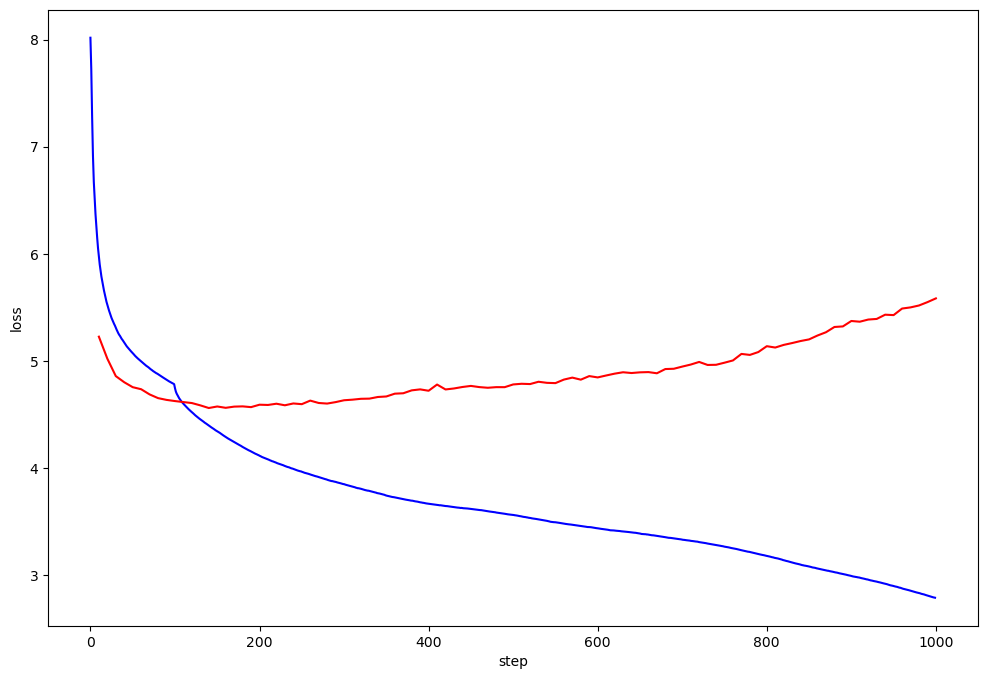

In [52]:
valid_loss_history = np.array(valid_loss_history)
train_loss_history =  np.array(train_loss_history)

plt.figure(figsize=(12,8))
plt.plot(train_loss_history[:,0],
         calc_moving_average(train_loss_history[:,1]), color='blue')

plt.plot(valid_loss_history[:,0],
         valid_loss_history[:,1], color='red')
plt.xlabel("step")
plt.ylabel("loss")